<h1><center>An Introduction to Sentiment Analysis</h1>

<center>Ryerson Burdick, Rick Jatti, Jimmy Nguyen</center>

---
This tutorial is part of a final project for CMSC320 at the University of Maryland, College Park.

## What is Sentiment Analysis? A Brief Introduction.

_Sentiment Analysis_ (or opinion mining) refers to the use of analytical techniques to automatically estimate emotional content of input signals. It most often refers to automatic sentiment detection in text or speech, in which case it is a task within the field of natural language processing (NLP). The field is far too broad to cover in a single tutorial, so we will focus exclusively on basic sentiment analysis for text applications.

<img src="https://raw.githubusercontent.com/ryersonburdick/SentimentAnalysisIntro/main/images/ai-terms_sentiment-analysis.png?token=ALODDPDCG6DSGBA4IY4DPU274ZFD6" title="Sentiment Analysis">
     
Image [source](https://lionbridge.ai/articles/5-essential-papers-on-sentiment-analysis/").

Automatic detection of sentiment from text is useful for a wide variety of reasons. It has many applications, including:
* Customer service
* Brand monitoring
* Healthcare
* Market research
* Recommender systems
* Social Media Analytics
* Surveys
* Human-computer interaction

In particular, the use of sentiment analysis for social media analytics and market research has skyrocketed in recent years as more businesses seek to benefit from vast quantities of information distributed online. Extracting meaningful insights from millions upon millions of tweets, reviews, posts, etc. requires analytical techniques which are continually increasing in sophistication as companies seek to exploit this information for a competitive advantage.

Aside from the many practical applications of sentiment analysis, it also poses a unique challenge for data science and artificial intelligence from a theoretical perspective. Over our evolutionary history, humans have developed remarkably complex and effective ways to relay and infer emotional content in our communications with one another. Manifestations of these complex methods in text pose significant obstacles for computers, which do not share our "natural" internal representation of human language. Inferring sentimental content of complex messages often requires a thorough understanding of both vocabulary and context. Consider the following sentences:

> 1. _I love data science!_
> 2. _Data science isn't my favorite, but I'd much rather learn it instead of learning about compilers._
> 3. _Oh, yeah, I'd \~totally\~ recommend taking a data science course to my friends :/._

Inferring the sentiment of the first sentence is relatively straightforwards; based on the text alone, it's pretty clear that the speaker is genuinely passtionate about data science. On a three-point scale {positive, negative, neutral}, this sentence would most likely be assigned __positive__ sentiment. The next two examples aren't quite as simple. The second sentence, for instance, conveys compound (multiple) sentiment. The speaker dislikes data science, but this negative sentiment is qualified by an apparently stronger dislike for compilers, in which case sentiment relevant to data science might be considered __neutral__ or even __positive__ depending on the context. The third sentence, although seemingly conveying positive sentiment, may actually contain sarcasm, which is both extremely difficult to convey through text and extremely difficult to detect automatically. In this case, the intended sentiment of the speaker may actually be __negative__. Development of algorithms capable of performing emotion inference in complex cases such as these will most surely help development of highly sophisticated general language models, which are both useful in their own right and a seemingly large leap in the direction of general AI.

This is just a brief overview of the practical applications and theoretical relevance of sentiment analysis. For more general background, try [this wiki page](https://en.wikipedia.org/wiki/Sentiment_analysis). For a great in-depth introduction, try [this article](https://monkeylearn.com/sentiment-analysis/). For a (relatively) recent survey on challenges in the field of sentiment analysis, see [here](https://www.sciencedirect.com/science/article/pii/S1018363916300071).

## Tools
---

For this tutorial, we will be using [Python](https://docs.python.org/3/) and a few notable data science libraries; notably, [numpy](https://numpy.org/doc/stable/), [pandas](https://pandas.pydata.org/docs/user_guide/index.html), [matplotlib](https://matplotlib.org/), and [scikit-learn](https://scikit-learn.org/stable/).

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import seaborn
import scipy.sparse as sparse
import random

## Data Collection
---

Both for convenience and for ease of following this tutorial, we decided to use datasets available on [Kaggle](https://www.kaggle.com/), a website for publicly sharing datasets and hosting popular machine learning competitions. Given the wide variety of practical applications for online sentiment analysis, we chose to integrate three different datasets. Each bullet provides a link to the Kaggle posting where the data can be downloaded:
1. [Amazon Review Dataset](https://www.kaggle.com/bittlingmayer/amazonreviews)
2. [Twitter Sentiment Analysis Dataset](https://www.kaggle.com/imrandude/twitter-sentiment-analysis)
3. [Airline Review Sentiment Analysis Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

## Data Processing
---

### Amazon Reviews

In order to begin analyzing our data, we first have to load it into our notebook. We will start with the Amazon review data. As specified in the dataset, the Amazon review data is in the [fastText](https://fasttext.cc/) format, which is standard formatting for data used by the text classification tool of the same name. We won't be using fastText in this particular tutorial, but it is an interesting and powerful utility for training automatic text classification models. Click the above link for more info.

The fastText format is as follows: data is stored in a plain text file in which each line corresponds to a document. The beginning of each line indicates the document label in the format `__label__X` where `X` is a label number, followed immediately by the text of the document. In our case, a "document" just represents a single review. Let's see what that looks like:

In [2]:
amazon_review_file = "data/amazon-reviews/test.ft.txt" # path to data file on my machine
# Print the first line
file = open(amazon_review_file, 'r', encoding="utf8")
print(file.readline())

__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"



We can check the total number of lines to know exactly how many documents we're dealing with. 

In [3]:
# Return pointer to beginning of file
file.seek(0)
print("Total reviews: {}".format(len(file.readlines())))

Total reviews: 400000


Now we need to go about converting this data into a more "data-science friendly" format. For that, we will be using a pandas DataFrame. A pandas DataFrame is a table data structure which provides many useful features for storing and manipulating data. Read more about pandas DataFrames [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

To store our fastText data in a pandas DataFrame, we will iterate over each line (document) in the text file. For each, we'll use a regular expression to extract the desired label, store it in a "label" column, and store the text in a "text" column. We will then use these columns (lists) to construct our DataFrame.

In [4]:
# Create a list to store labels
labels = []
# Create a list to store review text
texts = []
# Create a regex matching fastText label format
label_re = r'__label__[0-9]+'

file.seek(0)
# For each document
for line in file.readlines():
    # Extract label
    m = re.match(label_re, line)
    # If line contains appropriate label annotation
    if m:
        # Store label in labels list
        labels.append(m.group(0))
        # Get index where match ends
        end = m.span()[1]
        # Store document text in texts list
        # Add 1 to indx to remove space
        # Use .strip to remove trailing newline
        texts.append(line[end+1:].strip())
        
# Construct a dataframe using these lists
amazon_review_df = pd.DataFrame(data={'text':texts, 'label':labels})

We can view the first few entries in this dataframe to confirm we did everything right.

In [5]:
amazon_review_df.head()

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,__label__2
1,One of the best game music soundtracks - for a...,__label__2
2,Batteries died within a year ...: I bought thi...,__label__1
3,"works fine, but Maha Energy is better: Check o...",__label__2
4,Great for the non-audiophile: Reviewed quite a...,__label__2


We know from the data source that this particular dataset contains only two labels: negative (label 1) and positive (label 2). For ease of understanding, we can first convert labels to 'positive' or 'negative'.

In [6]:
label_convert = {'__label__1':'negative', '__label__2':'positive'}
amazon_review_df['label'] = amazon_review_df['label'].apply(lambda label: label_convert[label])

You may also have immediately noticed that the text contained in many of these reviews is messy: words are often misspelled, and capitalization and punctuation vary significantly from user to user. These will pose some challenges later, so it will be very beneficial to clean the text data now.

First, we'll define a function `clean_and_tokenize` which removes all capitalization and punctuation from an input string. We'd also like to remove spaces from our input string, splitting it into individual words (a process known as *tokenization*). For this, we'll use [NLTK](https://www.nltk.org/), a very popular natural language processing (NLP) library in Python. NLTK provides a function `word_tokenize` which performs the task of tokenization for us. 

In [7]:
nltk.download('punkt') # First download word tokenizer from nltk

def clean_and_tokenize(s):
    """Remove capitalization and punctuation from string."""
    
    # Remove capitalization
    s = s.lower()
    # Tokenization
    tokens = nltk.word_tokenize(s)
    # Remove punctuation
    tokens = [w for w in tokens if w.isalnum()]
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ryersonburdick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We can now apply this function to our data to clean it.

In [8]:
amazon_review_df['text'] = amazon_review_df['text'].apply(clean_and_tokenize)
amazon_review_df.head() # Verify that changes have been applied

,text,label
0,"[great, cd, my, lovely, pat, has, one, of, the...",positive
1,"[one, of, the, best, game, music, soundtracks,...",positive
2,"[batteries, died, within, a, year, i, bought, ...",negative
3,"[works, fine, but, maha, energy, is, better, c...",positive
4,"[great, for, the, reviewed, quite, a, bit, of,...",positive


Here is the same review we saw earlier.

In [9]:
print(amazon_review_df['text'].iloc[0])

['great', 'cd', 'my', 'lovely', 'pat', 'has', 'one', 'of', 'the', 'great', 'voices', 'of', 'her', 'generation', 'i', 'have', 'listened', 'to', 'this', 'cd', 'for', 'years', 'and', 'i', 'still', 'love', 'it', 'when', 'i', 'in', 'a', 'good', 'mood', 'it', 'makes', 'me', 'feel', 'better', 'a', 'bad', 'mood', 'just', 'evaporates', 'like', 'sugar', 'in', 'the', 'rain', 'this', 'cd', 'just', 'oozes', 'life', 'vocals', 'are', 'jusat', 'stuunning', 'and', 'lyrics', 'just', 'kill', 'one', 'of', 'life', 'hidden', 'gems', 'this', 'is', 'a', 'desert', 'isle', 'cd', 'in', 'my', 'book', 'why', 'she', 'never', 'made', 'it', 'big', 'is', 'just', 'beyond', 'me', 'everytime', 'i', 'play', 'this', 'no', 'matter', 'black', 'white', 'young', 'old', 'male', 'female', 'everybody', 'says', 'one', 'thing', 'who', 'was', 'that', 'singing']


Before we continue, we can convert the data from our other sources into the same format.

### Twitter Data
Unlike the Amazon review dataset, which is in a fastText format, our general twitter data is already stored as a csv, Pandas provides a convenient function for this, `read_csv`, which will load a csv file for us. Let's load the twitter dataset and glance at it.

In [10]:
path_to_twitter = "data/tweets-general/train.csv" # Path to twitter data on my machine
twitter_df = pd.read_csv(path_to_twitter, encoding='ISO-8859-1')
twitter_df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


This dataset contains an "ItemID" column, which is redundant with the DataFrame's index, so we can drop it. We can also rename the entries in the "Sentiment" column to be consistent with our previous dataset ({'positive', 'negative'}). Finally, we can perform the same text cleaning procedure we used for the Amazon dataset on this twitter dataset.

In [11]:
# Drop redundant column
twitter_df.drop(columns=["ItemID"], inplace=True)

# Rename entries in "Sentiment" column
num_to_cat_sentiment = {0: 'negative', 1:'positive'}
twitter_df['Sentiment'] = twitter_df['Sentiment'].apply(lambda label: num_to_cat_sentiment[label])

# Perform text cleaning and tokenization using function defined above
twitter_df['SentimentText'] = twitter_df['SentimentText'].apply(lambda s: clean_and_tokenize(str(s)))

# Rename the columns to be consistent with the previous dataset
twitter_df.rename(columns={'Sentiment':'label', 'SentimentText':'text'}, inplace=True)

Now we can verify the changes were applied.

In [12]:
twitter_df.head()

,label,text
0,negative,"[is, so, sad, for, my, apl, friend]"
1,negative,"[i, missed, the, new, moon, trailer]"
2,positive,"[omg, its, already, o]"
3,negative,"[omgaga, im, sooo, im, gunna, cry, i, been, at..."
4,negative,"[i, think, mi, bf, is, cheating, on, me]"


We can also determine how many samples this dataset contains.

In [13]:
print("Number of tweets: {}".format(len(twitter_df)))

Number of tweets: 99989


### Airline Review Dataset
Finally, we have to repeat this procedure for the final dataset of twitter airline ratings. Similar to the general twitter dataset, this dataset is also stored as a csv file. This makes loading it into a pandas dataframe quite easy.

In [14]:
path_to_airline = "data/tweets-airline/Tweets.csv" # Path to airline twitter dataset on my machine
airline_df = pd.read_csv(path_to_airline)
airline_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As you can see, this dataset contains far more information than the previous two datasets. In addition to raw text and sentiment label, this dataset also contains annotations for reasoning behind sentiment label determination, retweet count, twitter user handle, timezone and locational information, etc. For our purposes, we are primarily interested in just the raw text and the sentiment label. In light of this, we can simplify the dataset by creating a new dataframe with only this data.

In [15]:
airline_df = pd.DataFrame(data={'text':airline_df['text'], 'label':airline_df['airline_sentiment']})

We can also apply the same basic text cleaning procedure we used for the previous two datasets.

In [16]:
airline_df['text'] = airline_df['text'].apply(lambda s: clean_and_tokenize(s))
airline_df.head()

,text,label
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, you, added, commercials,...",positive
2,"[virginamerica, i, did, today, must, mean, i, ...",neutral
3,"[virginamerica, it, really, aggressive, to, bl...",negative
4,"[virginamerica, and, it, a, really, big, bad, ...",negative


There are two immediate problems. First, this dataset contains *three* sentiment labels {positive, negative, neutral} instead of the two found in both of the previous datasets {positive, negative}. This can be solved trivially by simply removing those tweets assigned neutral sentiment. 

Ideally, we would like to be able to capture as much information about sentiment as possible, and even those tweets expressing neutral sentiment contain valuable information. However, considering that we are performing a classification task, it would be unwise to attempt classification on data with a severe imbalance of classes. Considering that this neutral label is only found in one out of the three datasets, and it also happens to be the smallest dataset, we have far less neutral labels than both positive and negative labels. For this reason, we will ignore the neutral tweets entirely.

In [17]:
airline_df = airline_df[airline_df['label'] != 'neutral']

The second (potential) problem actually relates to tweet vocabulary. It appears from the above snapshot that a disproportionately high amount of these tweets are addressed directly to an airline (e.g. VirginAmerica). This means that the majority of tweets likely begin with an airline name. We can do some premature exploratory analysis to examine this hypothesis. We will count term frequency of all first words of the tweets in the airline review dataset and plot the most common ones in order.

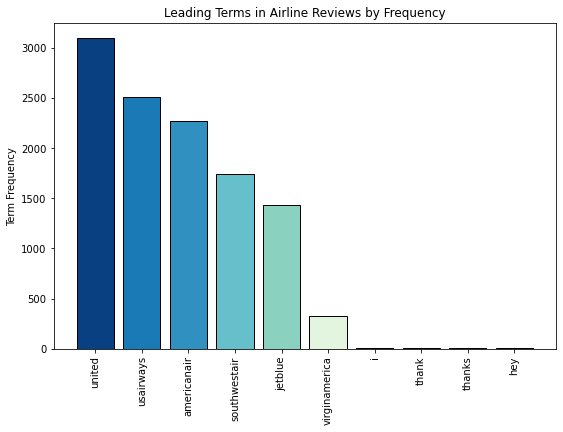

In [18]:
# Create a dict to track term frequency
term_freq = {}

# Iterate through all tweets
for tweet in airline_df['text']:
    first = tweet[0]
    
    # Update term frequency list with word
    # If already present, increment counter
    if first in term_freq.keys():
        term_freq[first] += 1
    # If not, add to term frequency dict
    else:
        term_freq[first] = 1

# Store word-frequency pairs in an assoc list
term_freq_list = [(w, term_freq[w]) for w in term_freq.keys()]
# Sort this assoc list by the frequency, highest to lowest
term_freq_list.sort(reverse=True, key=lambda pair: pair[1])

# Plot the 10 most frequent leading terms in this dataset
top_terms = [pair[0] for pair in term_freq_list[:10]]
top_freqs = [pair[1] for pair in term_freq_list[:10]]
# Create bar chart
plt.gcf().set_size_inches(9.0, 6.0)
colors = cm.GnBu([(x - min(top_freqs)) / max(top_freqs) for x in top_freqs])
plt.bar(top_terms, top_freqs, color=colors, edgecolor='black')
plt.xticks(rotation='vertical')
plt.title("Leading Terms in Airline Reviews by Frequency")
plt.ylabel("Term Frequency")
plt.show()

This plot seems to confirm our hypothesis; the frequency of airline mentions as leading words is far higher than any other word in this dataset. This is problematic from a classification standpont. For instance, if our dataset contains many more negative airline tweets than positive ones for a specific airline, a classification model might learn to associate the name of the particular airline with negative sentiment. Now, on its own, the sentiment associated with the name of a particular airline isn't inherently negative; learning this type of association might improve our performance on this particular dataset, but will likely harm its ability to generalize to other forms of text. It's unlikely that our other two datasets mention airline names frequently, if at all. 

We can visualize the ratio of positive to negative classes for a particular airline. Since United is the most popular, we'll chose them.

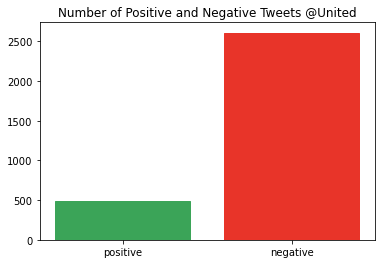

In [19]:
# Extract all tweets from airline_df which start with 'united'
united_tweets_indx = [text[0] == 'united' for text in airline_df['text']]
united_tweets = airline_df[united_tweets_indx]

# Split into positive tweets and negative tweets
united_pos = united_tweets[united_tweets['label'] == 'positive']
united_neg = united_tweets[united_tweets['label'] == 'negative']

# Plot positive and negative tweets
bars = plt.bar(['positive', 'negative'], [len(united_pos), len(united_neg)], edgecolor='black')
bars[0].set_color(cm.Greens(0.65))
bars[1].set_color(cm.Reds(0.65))
plt.title("Number of Positive and Negative Tweets @United")
plt.show()

It is clear from this plot that there are far more negative tweets directed @United than positive ones. Left unchanged, this means a model trained on this data might learn to label tweets as disproportionately negative if they begin with or contain "united". Considering that we are training a general sentiment classification model (i.e., not just airline reviews), this isn't necessarily behavior we'd like it to exhibit. Now, there are a few ways we could handle this. One way would be to simply hope that this word is filtered out when we select our final vocabulary. However, this would also filter out instances of the word "united" even when used in contexts entirely unrelated to the airline company. Instead, we'll opt to filter it out now, along with all the other names corresponding to airline companies, directly from the airline review data.

In [20]:
# List of airline names to filter out
airline_names = ['united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'virginamerica']
# For our purposes, we'll remove all instances of these company names from our airline dataset
airline_df['text'] = airline_df['text'].apply(lambda text: [w for w in text if w not in airline_names])

### Merging Datasets

Now that we have done the other preprocessing steps on the individual datasets, we can merge the three of them to create an aggregate dataset. First, we will add one more column to each of the three original dataframes which will indicate which original dataset a particular sample belongs to. Then, we can use pandas' [`DataFrame.append`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html) method to merge the three datasets into a master DataFrame. Note that normally, `DataFrame.join` can be used for merging different datasets, but because our datasets contain identical columns with only different entries, here we can simply use `DataFrame.append`.

In [21]:
# Add a dataset tag to the amazon reviews df
amazon_review_df['source'] = ['Amazon'] * len(amazon_review_df)
# ...and to the twitter df
twitter_df['source'] = ['Twitter'] * len(twitter_df)
# ...and to the airline df
airline_df['source'] = ['Airline'] * len(airline_df)

# Now, join all three into a master dataframe
master_df = amazon_review_df
master_df = master_df.append(twitter_df)
master_df = master_df.append(airline_df)
# Reset index to remove duplicate indices
master_df.reset_index(inplace=True)
master_df.head()

,index,text,label,source
0,0,"[great, cd, my, lovely, pat, has, one, of, the...",positive,Amazon
1,1,"[one, of, the, best, game, music, soundtracks,...",positive,Amazon
2,2,"[batteries, died, within, a, year, i, bought, ...",negative,Amazon
3,3,"[works, fine, but, maha, energy, is, better, c...",positive,Amazon
4,4,"[great, for, the, reviewed, quite, a, bit, of,...",positive,Amazon


## Exploratory Analysis and Visualization
---

Now, in addition to these separate datasets, it would be useful to train a sentiment analysis model on data from all three; ideally, this would improve its ability to generalize to text from various different sources. Before used the merged dataset, we should get an idea of how else these three datasets differ using some summary statistics. First, we can plot the ratio of positive and negative classes by dataset.

### Class Ratio

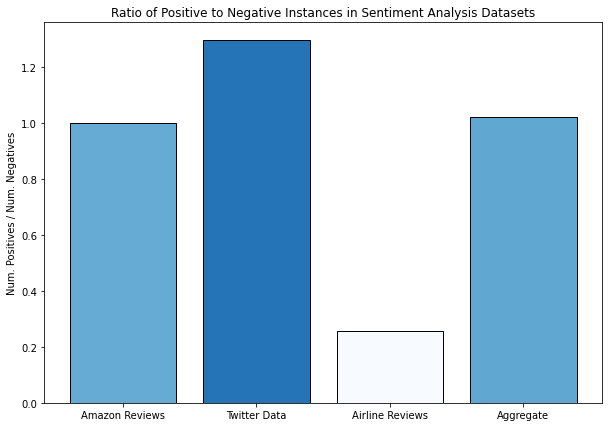

In [22]:
# Count positives and negatives from Amazon dataset
amazon_pos = len(amazon_review_df[amazon_review_df['label'] == 'positive'])
amazon_neg = len(amazon_review_df[amazon_review_df['label'] == 'negative'])
# Count positives and negatives from general twitter dataset
twitter_pos = len(twitter_df[twitter_df['label'] == 'positive'])
twitter_neg = len(twitter_df[twitter_df['label'] == 'negative'])
# Count positives and negatives from airline review dataset
airline_pos = len(airline_df[airline_df['label'] == 'positive'])
airline_neg = len(airline_df[airline_df['label'] == 'negative'])

# Plot ratio of positive to negative classes for all three datasets as well as aggregate ratio
plt.gcf().set_size_inches(10.0, 7.0)
bars = [(amazon_pos/amazon_neg), (twitter_pos/twitter_neg), (airline_pos/airline_neg),
         ((amazon_pos + twitter_pos + airline_pos)/(amazon_neg + twitter_neg + airline_neg))]
colors = cm.Blues([(x - min(bars) - 0.05) / (max(bars) + 0.05) for x in bars])
plt.bar(['Amazon Reviews', 'Twitter Data', 'Airline Reviews', 'Aggregate'],
        bars, color=colors, edgecolor='black')
plt.title('Ratio of Positive to Negative Instances in Sentiment Analysis Datasets')
plt.ylabel("Num. Positives / Num. Negatives")
plt.show()

The aggregate ratio appears to be very close to 1.0. This is a good thing; it indicates that if we were to merge our datasets in their current state, the split between positive and negative classes would be roughly 50-50.

### Document Lengths

Another summary statistic we might want to compute for each dataset is the average document length. This is less of a problem when using certain vectorization (embedding) methods, but for others, such as sequence models, it is an important consideration. We can compute the average document length for each dataset (including the aggregate) and plot it along with the distribution of document lengths for each dataset.

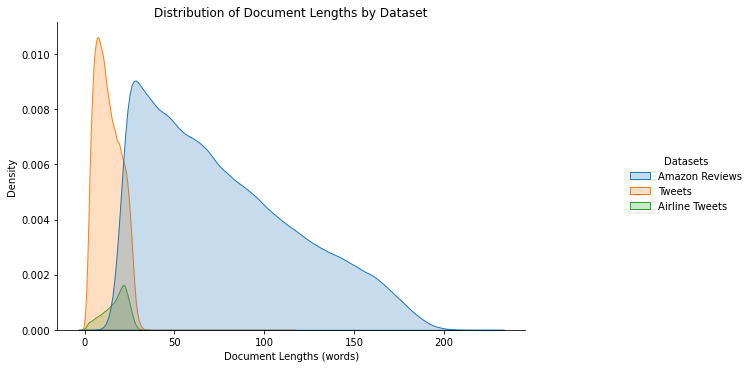

Average lengths:
	Amazon Reviews - 77.4063925
	General Tweets - 13.09712068327516
	Airline Tweets - 17.16610345723941
	Aggregate      - 63.4767051785819


In [23]:
# Compute length of each document in each dataset
amazon_lengths = [len(d) for d in amazon_review_df['text']]
twitter_lengths = [len(d) for d in twitter_df['text']]
airline_lengths = [len(d) for d in airline_df['text']]

# Compute average length for each dataset and aggregate
avg_len_amazon = sum(amazon_lengths) / len(amazon_lengths)
avg_len_twitter = sum(twitter_lengths) / len(twitter_lengths)
avg_len_airline = sum(airline_lengths) / len(airline_lengths)
avg_len_aggregate = ((sum(amazon_lengths) + sum(twitter_lengths) + sum(airline_lengths)) /
                     (len(amazon_lengths) + len(twitter_lengths) + len(airline_lengths)))

# Join lists of document lengths and create corresponding list of labels for multiple plotting
lengths = []
lengths.extend(amazon_lengths)
lengths.extend(twitter_lengths)
lengths.extend(airline_lengths)
names = ["Amazon Reviews"] * len(amazon_lengths)
names.extend(["Tweets"] * len(twitter_lengths))
names.extend(["Airline Tweets"] * len(airline_lengths))
plot_data = pd.DataFrame(data={'Document Lengths (words)':lengths, 'Datasets':names})

# Plot kernel density estimate of document length distribution for each dataset
seaborn.displot(plot_data, x="Document Lengths (words)", hue="Datasets", kind='kde', fill=True)
plt.gcf().set_size_inches(11.0, 5.0)
plt.title("Distribution of Document Lengths by Dataset")
plt.show()

# Print averages to compare summary statistics
print("Average lengths:")
print("\tAmazon Reviews - {}".format(avg_len_amazon))
print("\tGeneral Tweets - {}".format(avg_len_twitter))
print("\tAirline Tweets - {}".format(avg_len_airline))
print("\tAggregate      - {}".format(avg_len_aggregate))

As expected, the average lengths of Amazon reviews is far greater than the average lengths of both Airline review tweets and general tweets. This makes sense considering that tweets have a strict character limit while Amazon reviews do not. The effect of this length difference will likely depend on the method we choose to vectorize, or embed, our documents; depending on the method we choose, it may be necessary to truncate or remove certain documents of a particular length, so it will be important to keep this in mind.

### Term Composition and Stopword Removal

We should also get a good idea of the term composition of our documents. We can construct a similar plot to the one we had for leading terms in the airline review dataset, but we can plot data for all terms across all documents. Instead of "manually" counting term frequencies (which is rather slow), now that we are no longer isolating the first term, we can use a built-in frequency counter included with NLTK, `nltk.FreqDist`. See the documentation [here](http://www.nltk.org/api/nltk.html?highlight=freqdist).

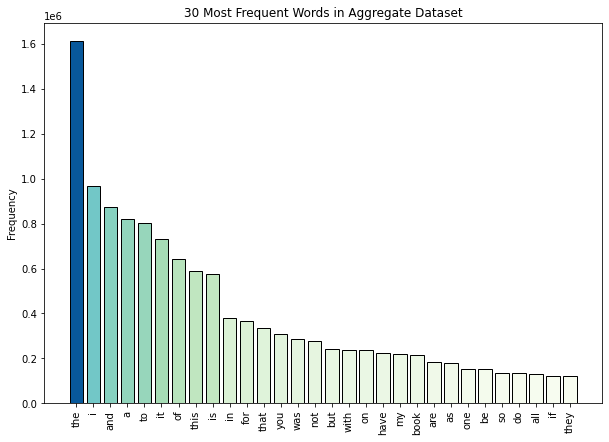

In [24]:
# Get a list of all words in our corpus
all_words = []
for text in master_df['text']:
    all_words.extend(text)
    
# Construct frequency count
freqs = nltk.FreqDist(all_words)

# Plot 30 most common words
bars = []
values = []
for word, freq in freqs.most_common(30):
    bars.append(word)
    values.append(freq)
    
# Construct bar chart
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.GnBu([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.title("30 Most Frequent Words in Aggregate Dataset")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.show()

The frequency counts are rather unsurprising. The most frequent words are *the*, *i*, *and*, *a*, etc. In NLP, these are often called *stopwords*: primarily short, functional words, such as articles and simple prepositions, which are frequently used but often carry relatively little informational value. Stopwords are often removed in preprocessing steps for NLP tasks, including sentiment analysis. NLTK provides a list of English stopwords which we can use to filter our frequency list.

First we'll obtain the list of English stopwords from NLTK and use it to filter out all stopwords from our master word list.

In [25]:
nltk.download('stopwords') # Download stopwords list if not present already
stopwords = nltk.corpus.stopwords.words('english')
# Remove stopwords from word list
all_words_sw_removed = [word for word in all_words if word not in stopwords]
# Construct frequency count
freqs_sw_removed = nltk.FreqDist(all_words_sw_removed)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryersonburdick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we can plot the filtered data in the same format as before.

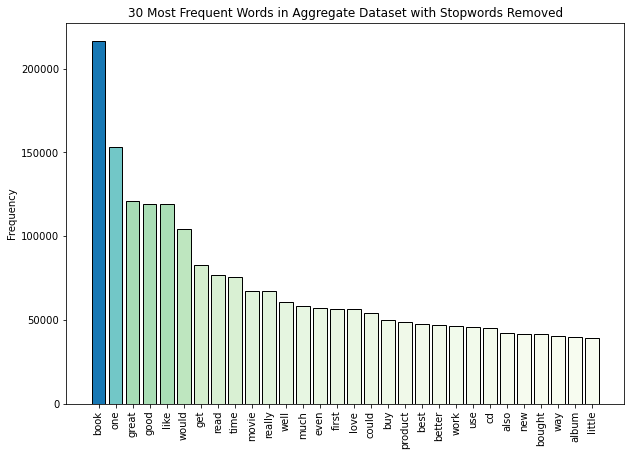

In [26]:
# Extract 30 most common words from this list and plot
bars = []
values = []
for word, freq in freqs_sw_removed.most_common(30):
    bars.append(word)
    values.append(freq)
    
# Construct bar chart
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.GnBu([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.title("30 Most Frequent Words in Aggregate Dataset with Stopwords Removed")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.show()

Finally, we can filter out stopwords from our original master dataframe. To conserve memory, we will filter out these stopwords from our lists of text in place and rename the column to reflect the change.

In [27]:
# Remove stopwords from all text lists in master df
master_df['text'] = master_df['text'].apply(lambda text: [w for w in text if w not in stopwords])
# Rename column to reflect change
master_df.rename(columns={"text":"text_sw_removed"}, inplace=True)

### Term Composition by Document Class

It might be useful to visualize the most common words by label; i.e., most frequent terms for positive sentiment documents and most frequent terms for negative sentiment documents. This can give us an idea of how the term composition of these two sets of documents differs, and gives some insight into what term-based features a classification model might exploit to determine whether a goven document will be assigned positive or negative sentiment.

First, we will create a master word list for both all positively-labeled documents and all negatively-labeled documents.

In [28]:
# Create master word list for all positive documents
positive_word_list = []
# Isolate all positive documents from master df
for text in master_df[master_df['label'] == 'positive']['text_sw_removed']:
    positive_word_list.extend(text)
    
# Create master word list for all negative documents
negative_word_list = []
# Isolate all negative documents from master df
for text in master_df[master_df['label'] == 'negative']['text_sw_removed']:
    negative_word_list.extend(text)
    
# Create frequency distributions for both positive and negative word lists
pos_freqs = nltk.FreqDist(positive_word_list)
neg_freqs = nltk.FreqDist(negative_word_list)

Now that we have these two frequency distributions, we can plot the most common words in documents labeled as having positive sentiment.

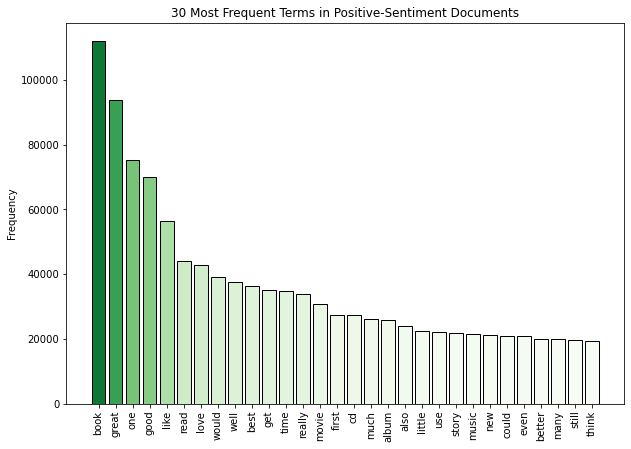

In [29]:
bars = []
values = []
pos_term_bars = []
# Plot 30 most common words in positively-labeled documents
for word, freq in pos_freqs.most_common(30):
    pos_term_bars.append(word)
    bars.append(word)
    values.append(freq)

# Construct bar plot
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.Greens([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("30 Most Frequent Terms in Positive-Sentiment Documents")
plt.show()

We can construct the same plot for negative documents.

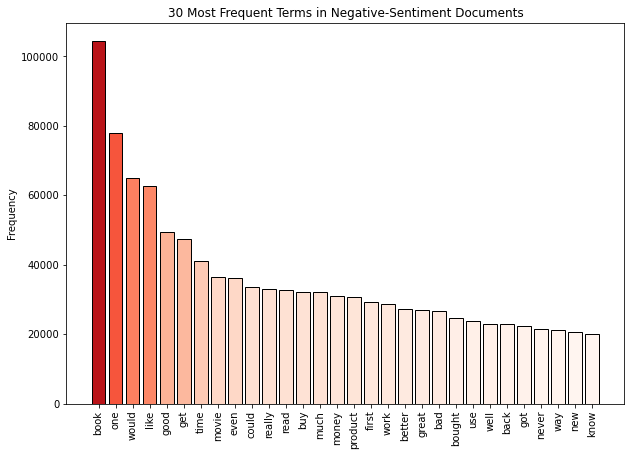

In [30]:
bars = []
values = []
neg_term_bars = []
# Plot 30 most common words in negatively-labeled documents
for word, freq in neg_freqs.most_common(30):
    neg_term_bars.append(word)
    bars.append(word)
    values.append(freq)

# Construct bar plot
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.Reds([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("30 Most Frequent Terms in Negative-Sentiment Documents")
plt.show()

Based on these plots, it seems there is much overlap between the most frequent terms in positively-labeled and negatively-labeled documents. It would be even more useful to plot the terms by the differences in occurence between positive and negative documents; this would give us a better idea of which words best *distinguish* the two classes.

We can do this first for positive classes.

In [31]:
# Create associative list of word-freq pairings containing all terms and corresponding difference in
# frequencies between positive and negative document sets
freq_diff_pos = [(word, pos_freqs[word] - neg_freqs[word]) for word in pos_freqs.keys()]
# Create same assoc list but for inverse (neg frequency - pos frequency)
freq_diff_neg = [(word, neg_freqs[word] - pos_freqs[word]) for word in neg_freqs.keys()]

# Sort both lists based on descending frequency differences
freq_diff_pos.sort(key=lambda x: x[1], reverse=True)
freq_diff_neg.sort(key=lambda x: x[1], reverse=True)

We can now create similar bar charts to the ones above, but instead of true term frequency, we will plot the terms with the greatest difference in number of occurences between all positive and all negative documents; i.e., plotting terms which best distinguish these classes.

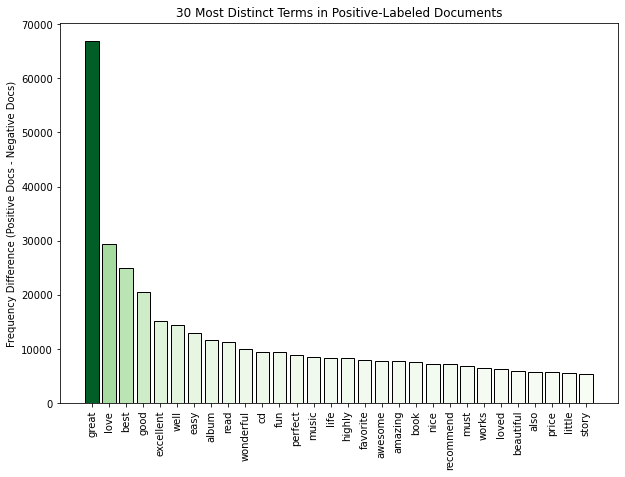

In [32]:
# Extract 30 terms which best distinguish positive from negative documents
bars = []
values = []
for (word, freq) in freq_diff_pos[:30]:
    bars.append(word)
    values.append(freq)
    
# Construct bar chart
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.Greens([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.title("30 Most Distinct Terms in Positive-Labeled Documents")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency Difference (Positive Docs - Negative Docs)")
plt.show()

This chart contains far more words which we would expect to fistinguish positive documents (e.g., "great", "love", "best", "good", "excellent", etc.). Based on the raw frequency differences, we can immediately expect the word "great" to be a **very strong** predictor of positive-sentiment documents.

We can produce the same plot for negatively-labeled documents.

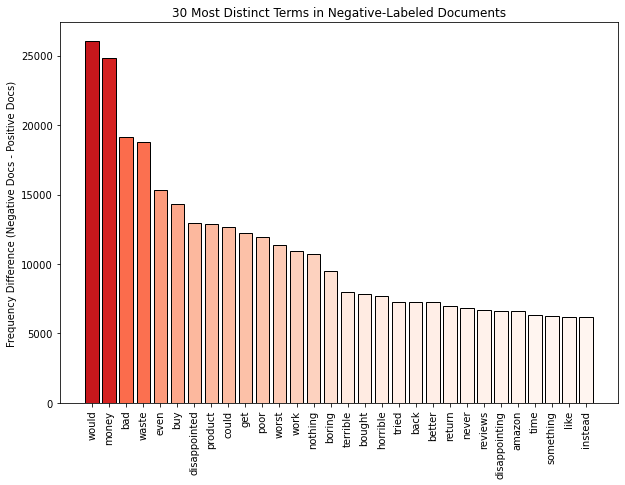

In [33]:
# Extract 30 terms which best distinguish negative from positive documents
bars = []
values = []
for (word, freq) in freq_diff_neg[:30]:
    bars.append(word)
    values.append(freq)
    
# Construct bar chart
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.Reds([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.title("30 Most Distinct Terms in Negative-Labeled Documents")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency Difference (Negative Docs - Positive Docs)")
plt.show()

We get similar results for negatively-labeled documents, though no single word is quite as strong a predictor as some of those in the positive-document vocabulary. However, we do see a number of words we would expect to distinguish negative documents from positive ones, namely "bad", "waste", "disappointed", etc.

### Stemming and Lemmatization
One additional text preprocessing step frequently employed in NLP is stemming or lemmatization. In human language, words can have various different forms (past tense, future tense, etc.) but often convey the same basic meaning. The size of a database containing all words in a corpus greatly increases in size if all forms of all words are recorded. Using stemming or lematization, we can reconcile these varous word forms into a single "base" or "root" word, vastly decreasing the number of words our algorithm is required to recognize.

For instance, consider the words: "connections", "connected", "connecting", "connection". They are all variants of the word "connect". Instead of having to account for many different forms of a word, Stemming allows NLP programs to focus on the root word instead. Stemming works by taking the suffix of a word away until a root word is found.

In [34]:
# Create the Stemmer
porter = PorterStemmer() 
# Create a list of example words
sample_stems = ['connections', 'connected', 'connecting', 'connection']
print ("Example words before Stemming: " + str(sample_stems))
# Loop through the example words and stem them
stemmed_sample = []
for s in sample_stems: 
    stemmed_sample.append(porter.stem(s))
print ("Example words after Stemming: " + str(stemmed_sample))

Example words before Stemming: ['connections', 'connected', 'connecting', 'connection']
Example words after Stemming: ['connect', 'connect', 'connect', 'connect']


Similarly, Lemmatization involves taking a word as input and deriving a base word out of it. In contrast to Stemming, Lemmatization also accounts for the meaning of the words. As a result, it is not restricted to just removing suffixes and it can output different words too.

In [35]:
nltk.download('wordnet'); # First download wordnet from nltk

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ryersonburdick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
lemmatizer = WordNetLemmatizer() 
example_lem = lemmatizer.lemmatize('better', pos = 'a')
print("The result of Lemmatizing \"better\" is \"" + str (example_lem) + "\"")

The result of Lemmatizing "better" is "good"


Typically Lemmatization is less efficient than Stemming and requires a machine learning background to implement it. As a result, Stemming is usually preferred because it is easier to implement and far more efficient as it primarily deals with string and suffix splicing.

Now, we'll apply Stemming to the words within the master DataFrame in their own column named 'stems'.

In [37]:
#airline_df['Stems'] = airline_df['text'].apply(lambda text: [w for w in text if w not in airline_names])
master_df['stems'] = master_df['text_sw_removed'].apply(lambda text: [porter.stem(w) for w in text])
master_df.head()

,index,text_sw_removed,label,source,stems
0,0,"[great, cd, lovely, pat, one, great, voices, g...",positive,Amazon,"[great, cd, love, pat, one, great, voic, gener..."
1,1,"[one, best, game, music, soundtracks, game, re...",positive,Amazon,"[one, best, game, music, soundtrack, game, rea..."
2,2,"[batteries, died, within, year, bought, charge...",negative,Amazon,"[batteri, die, within, year, bought, charger, ..."
3,3,"[works, fine, maha, energy, better, check, mah...",positive,Amazon,"[work, fine, maha, energi, better, check, maha..."
4,4,"[great, reviewed, quite, bit, combo, players, ...",positive,Amazon,"[great, review, quit, bit, combo, player, hesi..."


One thing we can analyze is the difference between the unaltered Terms with the alterred Stems. First, we form a list of all the stems and categorize them by their positive or negative labels.

In [38]:
# Generate a list of all stems and sort them by positive or negative labels
pos_stems = []
neg_stems = []
for index, rows in master_df.iterrows():
    if (rows['label'] == 'positive'):
        pos_stems += rows['stems']
    else:
        neg_stems += rows['stems']

Next, we obtain the 30 most common positive stems and graph them. Comparing the 30 Most Frequent Stems with the earlier 30 Most Frequent Terms, we get similar graphs. One difference is that the frequency increases in the Stem graph which is expected as more words are transformed into the stem words.

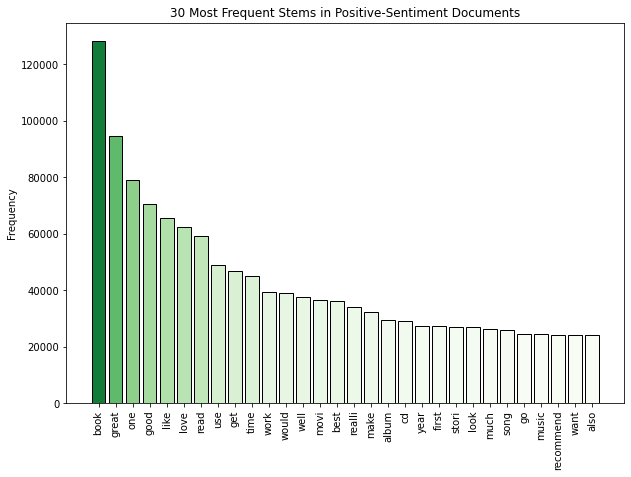

In [39]:
# Count the most common 30 positive stems
data_counter = Counter(pos_stems)
bars = []
values = []
pos_stem_bars = []
for (word, freq) in data_counter.most_common(30):
    pos_stem_bars.append(word)
    bars.append(word)
    values.append(freq)
    
# Construct bar plot
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.Greens([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("30 Most Frequent Stems in Positive-Sentiment Documents")
plt.show()

Similarly, we will count the 30 Most Common Negative stems and compare with the 30 Most Common Negative Terms. Likewise, we see an increase in the frequency as well as some differences on the X-axis.

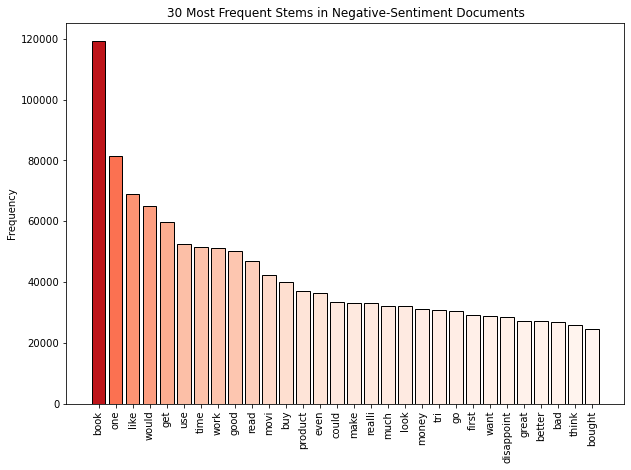

In [40]:
# Count the most common 30 negative stems
data_counter = Counter(neg_stems)
bars = []
values = []
neg_stem_bars = []
for (word, freq) in data_counter.most_common(30):
    neg_stem_bars.append(word)
    bars.append(word)
    values.append(freq)
    
# Construct bar plot
plt.gcf().set_size_inches(10.0, 7.0)
colors = cm.Reds([(x - min(values)) / max(values) for x in values])
plt.bar(bars, values, color=colors, edgecolor='black')
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("30 Most Frequent Stems in Negative-Sentiment Documents")
plt.show()

Now we analyze the differences in depth between the two sets of graphs. First, we'll start with the positive labels.

In [41]:
pos_diff = []
for word in pos_stem_bars:
    if word not in pos_term_bars:
        pos_diff.append(word)
print('Positve Words that are Stems, but not Terms', pos_diff)

pos_diff = []
for word in pos_term_bars:
    if word not in pos_stem_bars:
        pos_diff.append(word)
print('Positive Words that are Terms, but not Stems', pos_diff)

Positve Words that are Stems, but not Terms ['work', 'movi', 'realli', 'make', 'year', 'stori', 'look', 'song', 'go', 'recommend', 'want']
Positive Words that are Terms, but not Stems ['really', 'movie', 'little', 'story', 'new', 'could', 'even', 'better', 'many', 'still', 'think']


Here, we see that some of the Terms have been converted into Stems. For instance the term movie converts into the stem movi. Or really converts to realli.
Because of this conversion to stems, there are new words in the Top 30 Stems that we don't see in the Top 30 Terms such as 'look', 'song', 'go', 'recommend', and 'want'. Several of these words have positive denotations that we haven't seen before such as 'recommend'. So by Stemming the terms, we have found more words that may indicate positive sentiment.

Now, we shall analyze the negative sentiments.

In [42]:
neg_diff = []
for word in neg_stem_bars:
    if word not in neg_term_bars:
        neg_diff.append(word)
print('Negative Words that are Stems, but not Terms', neg_diff)

neg_diff = []
for word in neg_term_bars:
    if word not in neg_stem_bars:
        neg_diff.append(word)
print('Negative Words that are Terms, but not Stems', neg_diff)

Negative Words that are Stems, but not Terms ['movi', 'make', 'realli', 'look', 'tri', 'go', 'want', 'disappoint', 'think']
Negative Words that are Terms, but not Stems ['movie', 'really', 'well', 'back', 'got', 'never', 'way', 'new', 'know']


As expected, there are differences as Terms are converted into Stems. Additionally, we see new words in the Stems such as 'make', 'look', 'go', 'want', 'disappoint', and 'think'. The stem 'disappoint' in particular has a negative denotation and could prove to be a strong indicator of negative sentiment.

Now, comparing the new words in the positve and negative versions, we do see common words such as 'want'. Intuitively, 'want' would be a positive sentiment indicator, but this data suggests it may also be a negative indicator. Interestingly, as a result, having a positive or negative denotation may not indicate a similar connotation or sentiment. Thus, sentiment analysis may be trickier to analyze than one may think. For this, and other, reasons, we have decided not to perform stemming in this tutorial; however, stemming and lemmatization are both important concepts in NLP that you should be familiar with.

Now that we have conducted some useful and informative exploratory analysis and visualization of our data, we can move forwards towards creating a machine learning model to actually perform sentiment analysis.

## Data Analysis, Hypothesis Testing, and Machine Learning
-----------

All of the exploratory analysis and visualization of text we have done thus far has used text in its "natural" form, i.e. the form in which humans can read it. "Natural" text, however, it not in a form that is readily usable by most machine learning algorithms, which often rely on the manipulation of *feature vectors* through numerical methods. 

Certain types of data lend themselves to easy conversion into numerical formats. Arbitrary numbers of numerical features can be packaged into a feature vector, if necessary, and used as input to a machine learning algorithm. Images are already represented internally as matrices of numbers, so these can either be flattened into a feature vector or used as-is with some algorithms capable of operating on higher-dimensional numerical representations of data (e.g. Convolutional Neural Networks, [CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network)). When dealing with text, we are not quite so lucky.

How can we go about converting text into a feature vector?

### Bag-of-Words Representation

One of the earliest, simplest, and most common mechanisms for converting text into a feature vector representation is known as the [*bag-of-words model*](https://en.wikipedia.org/wiki/Bag-of-words_model). The intuition behind bag-of-words (BoW) is quite simple.

First, we will define a set of *n* terms which we will use to "define" a document; we will call this set of terms our *vocabulary*. Each word in our vocabulary is encoded with a one-hot encoding representation: a vector with a single index set to 1 while all other values are 0 (see [this HackerNoon article](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Here is a trivial example. Let's say we have a vocabulary consisting of three words: computer, information, and data. Our vocabulary size, *n*, is 3, so the vectors we compute for each word will be in $\mathbb{R}^3$:

<img title="bow-example1" src="https://raw.githubusercontent.com/ryersonburdick/SentimentAnalysisIntro/main/images/bow-example1.png?token=ALODDPCFMPPYNEGBVPHQZ7274ZFMM">

Computing a feature vector for a collection of text (i.e., a document) is easy: simply add up all the BoW vectors for each word in the document that appears in the vocabulary:

<img title="bow-example2" src="https://raw.githubusercontent.com/ryersonburdick/SentimentAnalysisIntro/main/images/bow-example2.png?token=ALODDPEJX62SUBRKGVAEHS274ZFNU">

If terms are repeated, we simply add their BoW feature vectors multiple times:

<img title="bow-example3" src="https://raw.githubusercontent.com/ryersonburdick/SentimentAnalysisIntro/main/images/bow-example3.png?token=ALODDPADSEQVWVWLIFLTVEC74ZFOY">

A BoW vector for a document, then, just encodes the *term frequency* of each word in our vocabulary.

A BoW (term-frequency) representation of a document is an easy-to-understand document embedding method which can be quite useful. However, two major problems with it are immediately apparent from these examples. First, some of the words in the sentences are ignored because they were not in our initial vocabulary, and second, frequent occurences of common words can account for a large portion of a document's vector representation. We'll briefly discuss each of these problems individually.

### Choosing a Vocabulary

One major issue with a bag-of-words representation is that a document's BoW embedding depends entirely on the vocabulary of words that is chosen. If the vocabulary is too small and restricted, the BoW vector will not be very representative of the full content of the document. If the vocabulary is too large, a document's representation will be very sparse (i.e., most entries in the BoW vector will likely be 0). A large vocabulary necessarily embeds documents in a very high dimensional space: as of 2020, there are approximately 171,000 words in the English language. This means that a BoW embedding of a document based on a vocabulary of the entire English language will produce a vector in $\mathbb{R}^{171000}$; adding slang words, typos, etc. will drastically increase this number. This produces obvious performance deficits due to memory requirements.

Additionally, and perhaps more importantly, embedding our data in such a high dimensional space renders us particularly vulnerable to *the curse of dimensionality*. The curse of dimensionality refers to the fact that as dimensions are added to a sample space (i.e., containing data points), the volume of that space increases exponentially. This has some undesirable side effects. One of these is that distance metrics between data points begin to "lose meaning": as dimensionality increases, the difference in distances between data points that might otherwise be close and those which might otherwise be far apart begins to *shrink*. This presents major problems for algorithms which rely heavily on distance metrics, such as nearest-neighbors classifiers (e.g. [k-NN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)) and most clustering algorithms. Another problem is that, due to the exponential increase in the volume of the sample space, our existing data points become more and more sparse as dimensionality increases. This generally means that we need exponentially more data to effictively "populate" a higher dimensional embedding space. In machine learning, data is everything, so an embedding method which drastically increases the amount of required data is generally not desirable.

We have already actually implemented one remedy to this problem: stopword removal. Removing stopwords necessarily decreases the size of our vocabulary by getting rid of common words that carry relatively little emotional information. However, we also need to restrict our vocabulary at the other end of the frequency spectrum: we shouldn't bother encoding our documents based on words that only appear once or twice in the entire corpus. One way to do this would be to predeterine a vocabulary size $k$ and take only the most frequent $k$ words as our vocabulary after removing the stopwords. Instead, we will set a minimum frequency threshold `min_term_freq`, and mandate that any word which appears fewer than `min_term_freq` times in our corpus is removed from our vocabulary. We can use the total number of documents $n$ as a heuristic for helping determine this frequency. Let's say we want to only consider words which appear in at least 0.1% of the documents in our corpus (one out of every thousand). Under the assumption that the rare words we want to filter out appear at most once per document, we can calculate the threshold as `min_term_freq` $= n*0.001$.

In [43]:
# Calculate total number of documents
n = len(amazon_review_df) + len(twitter_df) + len(airline_df)
# Use n to calculate minimum term frequency
min_term_freq = n * 0.001

Since we have already gone about removing stopwords, we can use this minimum term frequency threshold to restrict our vocabulary even further.

In [47]:
# Print initial vocab size
print("Initial Vocab Size: {}".format(len(freqs_sw_removed)))

vocab_with_freqs = []
# Iterate through all words
for word in freqs_sw_removed.keys():
    freq = freqs_sw_removed[word]
    # If frequency exceeds minimum threshold
    if freq > min_term_freq:
        vocab_with_freqs.append((word, freq))
        
# Isolate words in vocab
vocab = [pair[0] for pair in vocab_with_freqs]
        
# Print size of restricted vocabulary
new_size = len(vocab_with_freqs)
print("New Vocab Size: {}".format(new_size))
# Print ratio of vocab sizes
print("Ratio of Vocab Sizes: {:.5f}".format((new_size / len(freqs_sw_removed))))

Initial Vocab Size: 312128
New Vocab Size: 4024
Ratio of Vocab Sizes: 0.01289


Our new vocabulary is approximately 1.3% of the size of our original one; this is a massive decrease.

### TF-IDF

The other problem with BoW we want to address is the disproportionately high contribution of very frequent terms to a document's BoW embedding. In traditional bag-of-words representations, each term present in a document has an equal contribution (weighting) when determining its document vector. This doesn't do well for creating embeddings which best distinguish different documents in a corpus. As a trivial example, consider a vector similarity metric, such as cosine distance, ranking similarity between three documents. The similarity metric between two otherwise drastically different documents might be artificially inflated because their bag-of-words vectors have each encoded many uses of a common word, such as "good", "day", or "because".

One potential solution to this problem is to weight a term's frequency by some metric which estimates its "importance" to a document. This is exactly what term-frequency inverse-document-frequency ([tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) does. In a tf-idf embedding scheme, a term's frequency (tf) in a document is weighted by the inverse of the proportion of documents in which it appears throughout the entire corpus (idf). Usually, the logarithm of this inverse document frequency is taken to "dampen" increases in its value.

<img title="TF-IDF" src="https://raw.githubusercontent.com/ryersonburdick/SentimentAnalysisIntro/main/images/tfidf.png?token=ALODDPE64FWUSOOBBBAO3IC74ZFQK">

Here, $\mathrm{tf}_{i, j}$ is the frequency of term $i$ in document $j$, $N$ is the total number of documents in our corpus, and $\mathrm{df}_{i}$ is the number of documents in our corpus in which term $i$ appears at least once.

To vectorize the documents in our corpus using tf-idf, we can use scikit-learn's `TfidfVectorizer`. We can pass our vocabulary to the tf-idf vectorizer which it will use to create document vectors.

In [48]:
# First instantiate vectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
# Fit tf-idf vectorizer to our collection of documents and return vectors
tfidf_vectors = tfidf_vectorizer.fit_transform([" ".join(text) for text in master_df['text_sw_removed']])
# Convert to a list representation and add as column
master_df['tf-idf'] = [tfidf_vectors[i] for i in range(len(master_df))]

Now that we have vector embeddings for all documents in our corpus, we just have to convert our categorical labels to numerical ones. We will create a new column, `num_label`, where "negative" corresponds to 0.0 and "positive" correponds to 1.0.

In [49]:
# Create mapping from categorical to numerical labels
label_to_num = {"negative":0.0, "positive":1.0}
# Apply mapping
master_df['num_label'] = master_df['label'].apply(lambda label: label_to_num[label])

All of our data is now in a format that is readily usable by various machine learning algorithms, and we can begin our analysis.

### Partitioning the Data

Like any other application of supervised machine learning, we need to split our data into training and testing partitions such that we can evaluate our model of different data than that used to train it. Thankfully, scikit-learn provides a function `train_test_split` which is used exactly for this purpose.

The default training and testing split in scikit-learn is 75% training, 25% testing. We will keep this partition as it should hopefully provide us with a sufficiently large training set while also not compromising the generalizability of our testing results.

In [50]:
# Split data into training and testing partitions
X = master_df['tf-idf']
y = master_df['num_label']
# Perform split to isolate testing partition
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75)

# Show results
print("Number of Training Samples: {}".format(len(X_train)))
print("Number of Testing Samples: {}".format(len(X_test)))

Number of Training Samples: 383647
Number of Testing Samples: 127883


### Logistic Regression

For our analysis, we have decided to use a simple logistic regression model. Despite its simplicity, logistic regression has shown to be effective for a variety of NLP tasks, and is frequently used for term-based sentiment analysis models. 

<img title="sigmoid-function" src="https://raw.githubusercontent.com/ryersonburdick/SentimentAnalysisIntro/main/images/sigmoid-function.png?token=ALODDPBIKHXT4RA6PCLEEHC74ZFRQ">

A [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).

Logistic regression is an "adaptation" of multivariate linear regression allowing it to work for classification by tasking a standard linear model with predicting log-odds (logits). It does so by feeding the output of a standard linear model through a sigmoid function (see above). It is naturally a binary classification algorithm, which makes it well-suited for the present task (predicting positive vs. negative sentiment).

We will instantiate our logistic regression model, also provided by scikit-learn, before fitting it on our dataset. Scikit-learn's logistic regression model can take many optional parameters, including penalty, an intercept flag, a solver, etc., but we will be using the defaults because they are suitable for our application. By default, scikit-learn's logistic regression model is penalized using the $L_{2}$ norm: it's loss is increased by the sum of the squares of its parameters. This means that, in practice, a model that is accurate on its training dataset is still penalized heavily if its parameters take on extreme values. It is a form of regularization, and helps prevent against overfitting. Scikit-learn's model also fits an intercept term by default ($\theta_{0}$). Both of these defaults are acceptable, so we will not modify them. Logistic regression, unlike other algorithms such as random forests and k-NN, also has few if any hyperparameters to tweak, so we are lucky to avoid this step.

In [51]:
# Instantiate logistic regression model
model = sklearn.linear_model.LogisticRegression(max_iter=1000, verbose=1)

### Training our Model

We have chosen to keep the output of our tf-idf vectorizer unchanged. The default output is a scipy csr sparse matrix ([`scipy.sparse.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). In our input data matrix, each of the rows represents a tf-df vector for each document across our entire vocabulary. Because our vocabulary is quite large, the vast majority of terms are most likely *not* to appear in any randomly selected document. This means that for an arbitrary row, the majority of entries are likely to be 0. This is precisely what constitutes a sparse matrix.

Sparse matrix representations, such as the CSR representation which scikit-learn uses by default, are essentially more memory-efficient methods of storing and operating on sparse matrices than a standard "explicit" representation (in which all entries are stored in contiguous memory). Scikit-learn allows us to perform many operations, including training our logistic regression model, "naturally" on a sparse representation of data without first converting it. This will save us tremendous amounts of overhead!

Now it is time to fit our logistic regression model on our training data. Scikit-learn makes it easy to do so; we simply need to aggregate our training and testing samples before calling the `fit` method of our `LogisticRegression` classifier on our chosen data.

The code below first aggregates all data from each of our sections into single CSR sparse matrices. It does so using the method `scipy.sparse.vstack` which is specifically written for operating on these sparse representations. It then trains our logistic regression model on the appropriate data.

In [52]:
# Aggregate training data into single CSR matrix
X_train_sparse = sparse.vstack(X_train)

# Aggregate testing data into a single CSR matrix
X_test_sparse = sparse.vstack(X_test)

In [53]:
# Train our model on the training data
model.fit(X_train_sparse, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


LogisticRegression(max_iter=1000, verbose=1)

### Testing Our Model

Now that we have a trained logistic regression model, we can test our model on data is has not seen before; this is precisely the purpose of the testing set. We will first obtain our model's predictions on the inputs from the testing dataset.

In [54]:
test_preds = model.predict(X_test_sparse)

We can now use these testing predictions, along with the ground-truth (real) values of the samples in the testing set, to evaluate our model's performance.

### Performance Metrics

#### Classification Accuracy

The first (and most simple) metric we might like to use to evluate our model is a simple classification accuracy. This metric measures roughly what proportion of the testing samples our model correctly predicted.

In [55]:
acc = sklearn.metrics.accuracy_score(y_test, test_preds)
print("Model accuracy on testing dataset: {}".format(acc))

Model accuracy on testing dataset: 0.8418085281077234


We achieved approximately 84% accuracy on our testing dataset. This is a very good result!

However, simple classification accuracy is often not enough to determine a model's performance. For instance, it can be heavily impacted (i.e., artificially inflated) by many factors, including an imbalance of classes in the testing set. Additionally, the very notion of "classification accuracy" for a classification algorithm which outputs class probabilities (such as logistic regression) is entirely contingent on a (semi-arbitrary) decision threshold; for example, with a decision threshold of 0.5, a model which predicts the correct class with probability 0.51 gets the same "accuracy score" as one which predicts it with probability 0.99. Classification accuracy also does not provide any additional insight into a model's performance if mislabeling certain instances carries a higher consuquence than mislabeling others.

#### Confusion Matrix

Thankfully, some of these issues can be addressed by additional performance metrics. One of these additional metrics is a [*confusion matrix*](https://en.wikipedia.org/wiki/Confusion_matrix). A confusion matrix stores information about the frequency of erroneous predictions for instances of specific classes. For a binary classification problem, it stores the number (or percentage) of false positives, true positives, false negatives, and true negatives predicted. True positives and true negatives refer to correct predictions for positive and negative instances respectively, while false positives and false negatives refer to incorrent predictions for positive and negative instances respectively. A confusion matrix gives us a bit more insight into where our classification model is doing well and where it is struggling.

Like many other tools we have used thus far in our analysis, scikit-learn provides an easy-to-use implementation of a confusion matrix. We only need to give it our model's predictions on our testing set as well as the groun-truth labels for the testring data and it will calculate the rest for us.

In [56]:
# Construct confusion matrix given grount-truth and predicted labels for test data
sklearn.metrics.confusion_matrix(y_test, test_preds)

array([[52199, 10807],
       [ 9423, 55454]])

For clarity, we first normalize the values in the confusion matrix such that they represent each possible classification as a percentage of all instances in the test set. Then, we can extract the information from tthe returned array and display it in a more illuminating format. Note that the rows of this matrix represent the true labels of the instances while the columns represent the predicted labels.

We will display this confusion matrix using the [seaborn](https://seaborn.pydata.org/) library, which we previously used to display the distribution of word lengths.

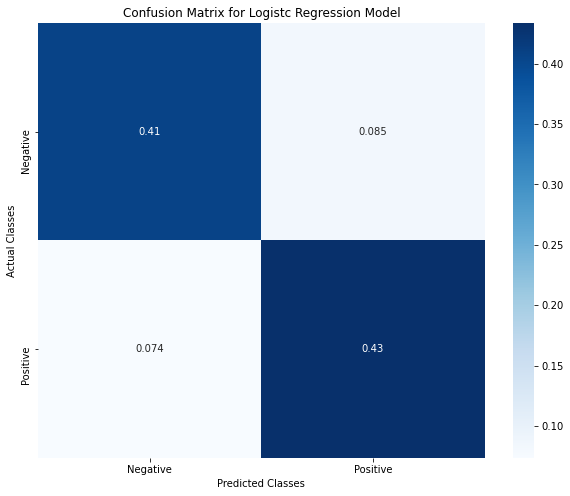

In [57]:
mat = sklearn.metrics.confusion_matrix(y_test, test_preds, normalize="all")
seaborn.heatmap(mat, annot=True, 
                xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"],
                cmap=cm.Blues)

plt.gcf().set_size_inches(10.0, 8.0)
plt.title("Confusion Matrix for Logistc Regression Model")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

This confusion matrix is much more insightful into the actual performance of our model than simply classification accuracy. It tells us that 43% of samples in the testing set were positive instances that the model correctly classified, and 41% were negative instances that the model correctly classified. This account for the approximate 84% classification accuracy overall. The confusion matrix also tells us that 8.3% of testing instances were negative instances that were misclassified as positive, and 7.3% of instances were positive that were misclassified as negative. This confirms our earlier result that the model performed very well overall.

#### ROC and AUC

One final performance metric we can use is the [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc), which stands for Area Under (ROC) Curve. As mentioned earlier, simple metrics such as pure classification accuracy are relatively limited in their ability to reveal general information about model performance due to their reliance on a fixed and "semi-arbitrary" *decision threshold*. The reciever operating characteristic (ROC) curve helps us visualize the performance of our model at various values of this decision threshold (rather than just one). It requires two values: the true positive rate (TPR) and the false positive rate (FPR). The true positive rate is calculated as the ratio of true (correct) positive predictions over all positive instances in the dataset, while the false positive rate is calculated as the ratio of false (incorrect) positive predictions over the number of all negative instances in the dataset. Plotting the TPR against the FPR for various decision thresholds gives the ROC curve.

When the ROC curve for one particular classification model is "higher" than the other, it means that its ratio of true positives to false positives is generally higher. This indicates that it makes more correct predictions at all values of the decision threshold [0.0, 1.0]. The way that we mathematically capture whether or not one ROC curve is "higher" (and by how much) is by taking the area under it using integration: this is precisely what AUC measures. An AUC close to 1.0 indicates a very strong (accurate) classification model, while one close to 0.0 indicates a very weak (inaccurate) model.

Scikit-learn provides another utility for evaluating model performance using both ROC and AUC. We will use these utilities, `roc_curve` and `roc_auc_score`, to evaluate our logistic regression model. We will plot the ROC curve along with the identity function for reference.

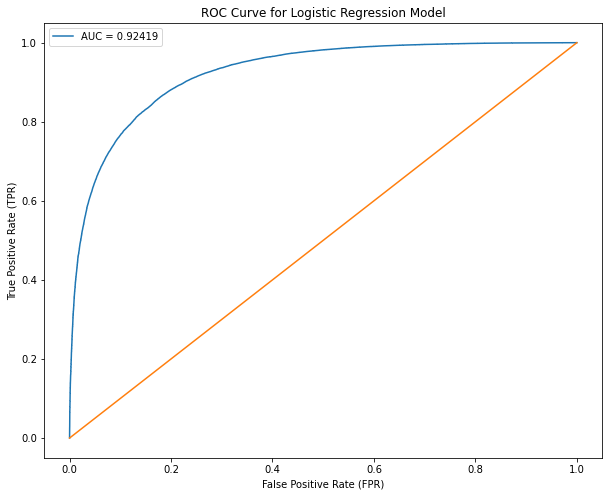

In [58]:
# ROC computation requires probabilistic predictions (i.e., probaility of predicted classes rather than
# binary labels)
prob_preds = model.predict_proba(X_test_sparse)
# Extract only probability of positive class (P(y=1))
prob_preds = [pair[1] for pair in prob_preds]

# Use probabilities and ground-truth labels to compute roc curve
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, prob_preds)
# Plot TPR against FPR to obtain ROC curve
plt.plot(fpr, tpr)
# Plot identity function for reference (where TPR = FPR)
ident = np.linspace(0.0, 1.0)
plt.plot(ident, ident)
plt.title("ROC Curve for Logistic Regression Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")

# Compute AUC and display inside plot using plt.legend()
auc = sklearn.metrics.roc_auc_score(y_test, prob_preds)
plt.legend(["AUC = {:.5f}".format(auc)], loc="best")

plt.gcf().set_size_inches(10.0, 8.0)
plt.show()

Our model achieved an AUC score of 0.92: a very good result! This, along with our previous performance metrics, indicates that our classification model is quite powerful and accurate. We can see it's performance more tangibly by examining a few samples from our test set and the model's predictions for them.

#### Examining Samples from the Test Set

In [59]:
# Define conversion from numerical to text labels
num_to_text = {0.0:"Negative", 1.0:"Positive"}

# Iterate over the first 5 samples from the test set
for i in range(5):
    # Obtain text
    text = " ".join(master_df['text_sw_removed'].iloc[i])
    # Obtain true label
    label = master_df['label'].iloc[i].capitalize()
    
    # Obtain corresponding vector
    x = master_df['tf-idf'].iloc[i]
    # Obtain model prediction
    model_pred = num_to_text[model.predict(x)[0]]
    # Obtain model confidence (probability)
    model_prob = model.predict_proba(x)[0][1]
    # If label is negative, convert probability of positive class to probability of negative class
    if model_pred == "Negative":
        model_prob = 1 - model_prob
        
    # Display
    print("Text: {}\nTrue Label:       {}\nPredicted Label:  {}\nConfidence:       {:.5f}".format(
        text, label, model_pred, model_prob))
    print("-------------------")

Text: great cd lovely pat one great voices generation listened cd years still love good mood makes feel better bad mood evaporates like sugar rain cd oozes life vocals jusat stuunning lyrics kill one life hidden gems desert isle cd book never made big beyond everytime play matter black white young old male female everybody says one thing singing
True Label:       Positive
Predicted Label:  Positive
Confidence:       0.92278
-------------------
Text: one best game music soundtracks game really play despite fact played small portion game music heard plus connection chrono trigger great well led purchase soundtrack remains one favorite albums incredible mix fun epic emotional songs sad beautiful tracks especially like many kinds songs video game soundtracks must admit one songs distant promise brought tears eyes many one complaint soundtrack use guitar fretting effects many songs find distracting even included would still consider collection worth
True Label:       Positive
Predicted Labe

Although this is an extremely small sample, our model not only seems to be quite accurate, but its output is sensible and it appears to predict what we might call "obvious" instances with reasonably high certainty. This is a good sign!

### Testing on Synthetic Data

Now we can examine the output of our model on some synthetic tweets (which we have created). This is not a rigorous testing procedure by any means, but it is interesting to see how our classifier might handle them. 

In [60]:
# Opening file from my machine
synth_file = open("data/synthetic/synth_tweets.txt", 'r', encoding='utf-8-sig')
synth_tweets = synth_file.readlines()

# Removing newline characters
synth_tweets = [i.strip() for i in synth_tweets]
for i in synth_tweets:
    print(i)
    print("-------------")

This sixty year old lady next to me at the bar asked what’s with the suit like she could tell i shouldn’t be wearing a suit. she’s right but very insulting
-------------
where’s the dislike button when i need it
-------------
Alright guys, those of you getting your results today, good luck. Remember grades do not define you as a person
-------------
Sending love out to all delivery drivers. You are a massive part of our lives. You bring happiness.
-------------
NFL attendance and ratings are WAY DOWN. Boring games yes, but many stay away because they love our country. League should back U.S.
-------------


Some of these Tweets are slightly more ambiguous than the first 5 in our test set. We can still categorize their polarity pretty easily as humans with understanding of the English language, but how well will the model do? Let's go ahead and insert these tweets, as well as their corresponding polarity, into a DataFrame.

In [61]:
synth_labels = ["negative", "negative", "positive", "positive", "negative"]
synth_data = pd.DataFrame(data={'text':synth_tweets, 'label':synth_labels})

Now we will go ahead and complete the same processes as before the get our data ready for vectorization and classification.

In [62]:
# Clean the data with our previously defined function
synth_data['cleaned_text'] = synth_data['text'].apply(clean_and_tokenize)
# Remove the stopwords
synth_data['cleaned_text'] = synth_data['cleaned_text'].apply(lambda text: [w for w in text if w not in stopwords])
# Retain only the words we have designated in our vocabulary
synth_data['text_vocab'] = synth_data['cleaned_text'].apply(lambda text: [word for word in text if word in vocab])

# Return vectors with our previously fitted vectorizer
synth_vectors = tfidf_vectorizer.transform([" ".join(text) for text in synth_data['text_vocab']])
synth_data['tf-idf'] = [synth_vectors[i] for i in range(len(synth_data))]
# Map from categorical to numerical labels
synth_data['num_label'] = synth_data['label'].apply(lambda label: label_to_num[label])

Since we haven't yet, let's look at what our data looks like now.

In [63]:
synth_data.head()

,text,label,cleaned_text,text_vocab,tf-idf,num_label
0,This sixty year old lady next to me at the bar...,negative,"[sixty, year, old, lady, next, bar, asked, sui...","[year, old, lady, next, bar, asked, suit, like...","(0, 2930)\t0.2933198007201966\n (0, 2215)\t...",0.0
1,where’s the dislike button when i need it,negative,"[dislike, button, need]","[dislike, button, need]","(0, 2382)\t0.7137655022975303\n (0, 509)\t0...",0.0
2,"Alright guys, those of you getting your result...",positive,"[alright, guys, getting, results, today, good,...","[alright, guys, getting, results, today, good,...","(0, 3518)\t0.4441527364687416\n (0, 2381)\t...",1.0
3,Sending love out to all delivery drivers. You ...,positive,"[sending, love, delivery, drivers, massive, pa...","[sending, love, delivery, drivers, massive, pa...","(0, 3673)\t0.40632349157582387\n (0, 2734)\...",1.0
4,NFL attendance and ratings are WAY DOWN. Borin...,negative,"[nfl, attendance, ratings, way, boring, games,...","[ratings, way, boring, games, yes, many, stay,...","(0, 2527)\t0.46134416902633735\n (0, 1796)\...",0.0


Finally, let's see how our model predicts the sentiments of these Tweets we've pulled straight from real accounts on Twitter.

In [64]:
for i in range(len(synth_data)):
    # Obtain text
    text = (synth_data['text'].iloc[i])
    # Obtain true label
    label = synth_data['label'].iloc[i].capitalize()
    
    # Obtain corresponding vector
    x = synth_data['tf-idf'].iloc[i]
    # Obtain model prediction
    model_pred = num_to_text[model.predict(x)[0]]
    # Obtain model confidence (probability)
    model_prob = model.predict_proba(x)[0][1]
    # If label is negative, convert probability of positive class to probability of negative class
    if model_pred == "Negative":
        model_prob = 1 - model_prob
        
    # Display
    print("Tweet: {}\nTrue Label:       {}\nPredicted Label:  {}\nConfidence:       {:.5f}".format(
        text, label, model_pred, model_prob))
    print("-------------------")

Tweet: This sixty year old lady next to me at the bar asked what’s with the suit like she could tell i shouldn’t be wearing a suit. she’s right but very insulting
True Label:       Negative
Predicted Label:  Positive
Confidence:       0.56936
-------------------
Tweet: where’s the dislike button when i need it
True Label:       Negative
Predicted Label:  Negative
Confidence:       0.78138
-------------------
Tweet: Alright guys, those of you getting your results today, good luck. Remember grades do not define you as a person
True Label:       Positive
Predicted Label:  Positive
Confidence:       0.69710
-------------------
Tweet: Sending love out to all delivery drivers. You are a massive part of our lives. You bring happiness.
True Label:       Positive
Predicted Label:  Positive
Confidence:       0.83244
-------------------
Tweet: NFL attendance and ratings are WAY DOWN. Boring games yes, but many stay away because they love our country. League should back U.S.
True Label:       Nega

Despite the fact that we know our model isn't 100% accurate, it actually evaluated all 5 of these Tweets correctly! Note that, with the first tweet, we purposefully inserted a relatively ambiguous example and our model was still able to classify it correctly.

### Evaluating Feature Importance

Now that we have our fitted, tested model, we can gain some insight into the way it is making predictions. For instance, we might want to know the exact features (i.e., terms) which it deems most important to predicting specific classes.

To examine feature importance, we can simply calculate the coefficient associated with each term in the input vector to our model. Then, we can split these terms by class (positively-weighted terms vs. negatively-weighted terms) and sort them by the magnitude of their coefficients. This should give us an idea of which terms contribute strongly to the prediction of positive and negative documents, as well as the magnitude of their contribution.

In [74]:
# Obtained coefficients from fitted model
coefs = model.coef_.transpose().tolist()
# Create assoc list matching vocab terms with corresponding coefficient
terms_with_coefs = [(vocab[i], coefs[i][0]) for i in range(len(vocab))]
# Isolate negative terms according to model
negative_terms = [p for p in terms_with_coefs if p[1] < 0]
# Isolate positive terms according to model
positive_terms = [p for p in terms_with_coefs if p[1] > 0]
# Sort these lists in order of decreasing magnitude of the term weight
negative_terms.sort(key=lambda x: x[1])
positive_terms.sort(key=lambda x: x[1], reverse=True)

Now that we have these sorted lists, we can display the 10 "strongest" predictors (terms) for documents of each class according to our trained model.

In [76]:
print("10 Strongest Predictors for Positive Sentiment Documents")
for i in range(10):
    term = positive_terms[i][0]
    weight = positive_terms[i][1]
    print("\tTerm: \"{}\", Weight: {:.5f}".format(term, weight))
print("10 Strongest Predictors for Negative Sentiment Documents")
for i in range(10):
    term = negative_terms[i][0]
    weight = negative_terms[i][1]
    print("\tTerm: \"{}\", Weight: {:.5f}".format(term, weight))

10 Strongest Predictors for Positive Sentiment Documents
	Term: "excellent", Weight: 10.19501
	Term: "great", Weight: 10.07936
	Term: "perfect", Weight: 7.39429
	Term: "wonderful", Weight: 6.79691
	Term: "highly", Weight: 6.70898
	Term: "amazing", Weight: 6.55414
	Term: "fantastic", Weight: 6.49882
	Term: "best", Weight: 6.42105
	Term: "pleased", Weight: 6.41093
	Term: "awesome", Weight: 6.02152
10 Strongest Predictors for Negative Sentiment Documents
	Term: "disappointing", Weight: -13.18289
	Term: "worst", Weight: -11.73915
	Term: "waste", Weight: -11.69313
	Term: "disappointment", Weight: -11.33699
	Term: "disappointed", Weight: -9.90912
	Term: "poor", Weight: -9.72560
	Term: "poorly", Weight: -9.35582
	Term: "boring", Weight: -9.08437
	Term: "terrible", Weight: -8.90956
	Term: "horrible", Weight: -8.71272


## Conclusion
---

We hope this has served as an informative introduction to the task of sentiment analysis. Much like the written language on which it is based, sentiment analysis from text is rich with nuance; this is a major reason why it is often very difficult. There are many variables that need to be addressed before beginning data analysis, and how we deal with these variables changes depending on the task. Take stopwords, for example. Our project was entirely based in "polarity", or classifying things as strictly positive or negative (polarity often includes neutral as well). In a more complicated sentiment analysis project, maybe one designed to detect emotion, the frequency of various words normally classified as stopwords may indicate a certain emotion, especially when dealing with the spoken word rather than the written word. The effect of various preprocessing steps, such as stopword removal and stemming, also depends on the neture of the specific application. For instance, you can't delete the stopwords "the" or "who" when classifying tweets about rock bands.

Our classfier, as stated above, is a simple logistic regression model. Historically, this machine learning technique has performed far better than more traditional, less flexible rule-based approaches. The umbrella of machine learning approaches, however, includes many other methods. [Naïve Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), which incorporates Bayes theorem and probabilistic classifiers, determines classification by using word frequencies and calculating probabilities of different words from training data. [Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine) use distance metrics and kernel functions to determine a linear decision boundary between data points; this is often done using similar document vectors (tf-idf) to those we constructed in this tutorial. 

Sentiment analysis, and the field of NLP as a whole, have more recently been revolutionized by a major shift towards more complex [deep learning](https://en.wikipedia.org/wiki/Deep_learning)-based approaches. These approaches leverage sophisticated models called neural networks and their many variants to learn complex non-linear transformations on data. Many deep learning approaches for NLP, such as sequence models ([seq2seq](https://google.github.io/seq2seq/)) and, more recently, transformers (such as Google's [BERT](https://arxiv.org/abs/1810.04805) and OpenAI's [GPT-2](https://openai.com/blog/better-language-models/)), use a variety of components with millions or billions of parameters to train. Fitting models of this size requires incredibly powerful computing architecture, billions or even *trillions* of data points, sophisticated mechanisms for parallelization of training steps, and **lots** of time. Still other deep learning approaches focus instead on the *representation* of language data rather than the transformations which can be performed on it (although these are inextricably linked). Neural word embeddings, such as those produced by [word2vec](https://en.wikipedia.org/wiki/Word2vec) and [GloVe](https://nlp.stanford.edu/projects/glove/), are more dense (lower dimensional) word vectors produced by feeding word proximity data into sopisticated deep neural networks. These embeddings encode useful word information in a representation which is more computationally favorable due to its drastically reduced size (e.g., 256 entrieds as opposed to 2,000+). The most exciting results in the field of sentiment analysis, and NLP in general, have recently been achieved through the combination of these tactics.

Our approach, while definitely on the simpler side of models used for sentiment analysis, seems to have performed quite well. Not only was the accuracy of our model 84%, but our AUC score came out to .92, and our confusion matrix shows a high percentage of instances that were classified correctly. To achieve a *deployable* sentiment analysis model, however, there are various things we have to consider or eliminate that we have not in this project. For one, most polarity based analyses include a "Neutral" sentiment. Some even take a finer grained approach, including classfications like "Very Positive" or "Slightly Negative". The documents we used took text from two different platforms, and while our objective was not to create a model that works for any text from any source, a working general sentiment model would have to pull data from all types of platforms. It's also worth mentioning that our datasets had vastly different sizes, and it's possible that the much larger number of Amazon reviews could've heavily pushed the model in a certain direction.

This tutorial gave us a peek into the exciting world of sentiment analysis. There's still so much to learn about this field, and many more complex methods of sentiment analysis can help us further understand how to deal with edge cases like double negation, sarcasm, or multilingual examples. If you are interested in learning more, we encourage you to click some of the links above, explore some online courses such as Coursera's [Intro to Deep Learning](https://www.coursera.org/learn/intro-to-deep-learning) or see this article on [how to get started with NLP](https://towardsdatascience.com/how-to-get-started-in-nlp-6a62aa4eaeff).